# Washington_RPV_2020_Tracts_06_30_2023

## Background:
- We received a request for voter registration by party and voter turnout by primary contest (Republican and Democratic) for the 2022 Primary Election, voter turnout for the 2022 General Election, 2020 VAP by race/ethnicity, 2021 CVAP by race/ethnicity, 2020 Presidential and Gubernatorial contests, and 2022 Senate results on 2020 Census Tracts.

## Approach:
Voter file data was provided by L2. Voter file data is retrieved at the individual level and aggregated to 2020 tracts using a spatial join. Not all individuals are able to be aggregated as they do not all contain a latitude, longitude coordinate or contain inaccurate coordinates (i.e. not geocoded). Party registration data is modeled by L2 based entirely on academic modeling. Because voters can vote for candidates in any party, the primary voter turnout by party is based on the modeled registration (only 4 individuals appear to be an exception to this). Voter file data on 2020 tracts is then grouped by tracts assignment and joined with the tract file.

The tract file containing 2020 demographic data is from the Census PL 94-171 release. We used the "Alone" values where indicated above in the Fields section (a single variable in the PL data) and summed all respective columns including that race/ethnicity for those that are listed as "any part".

2022 Senate election results were retrieved from the [Washington Secretary of State (SOS)](https://www.sos.wa.gov/elections/research/2022-general-election.aspx) and joined to the 2022 shapefile also retrieved from the [SOS](https://www.sos.wa.gov/elections/research/Precinct-Shapefiles.aspx). These data were disaggregated using a modified Voting Age Population (VAP) variable where the adult incarcerated population is removed to calculate data at the 2020 block level. The results differ by a total of 4 for Murray and match the official totals exactly for other candidates.

Other 2020 block level data include CVAP and 2020 election results. 2021 CVAP data is provided by the Census at the block group level and the RDH has disaggregated this data to the block level using a racially-sensitive disaggregation to maintain racial distribution inside the block group. 2020 election results on precinct boundaries are originally provided by the [Voting Election and Science Team](https://dataverse.harvard.edu/file.xhtml?fileId=5007851&version=40.0) and disaggregated by the RDH to the block level using a modified VAP variable. 

All 2020 block level data (2022 Senate, 2020 VAP, 2021 CVAP) was joined together on the GEOID20 field and assigned a "best fit" tract using [maup](https://github.com/mggg/maup). These data were then grouped and summed by this assignment to then have all data (2020 election results, 2020 voter file, 2022 Senate results, 2020 VAP, and 2021 CVAP) on 2020 tract shapes. 

The data was checked for accuracy and exported as a CSV and SHP.

Please note that the 2021 CVAP data for CVAP_ASN21 and CVAP_AIA21 represent alone or in combination (Asian Alone + Asian and White, and Native American Alone + Native American and Black + Native American and White), which is slightly different than the VAP values, as those are represented as just "Alone". Moreover, the CVAP_BLK21 represents a sum of all available CVAP data (Black Alone + Black and White + Black and Native American) but the VAP data is more encompassing, including more fields as the PL data provides more racial categories. It is also to be noted that all CVAP data is Non-Hispanic, while in VAP it varies depending on the field (as noted in the description and column name).

For a 'raw-from-source' folder containing CVAP and PL data and 2020 and 2022 election results, contact info@redistrictingdatahub.org. Individual level voter file data cannot be provided.

Import necessary libraries

In [1]:
import os
import pandas as pd
import geopandas as gp
import maup
pd.set_option('display.max_columns', None)
wd = os.path.join(os.getcwd(),'raw-from-source')

Import all necessary datasets (voterfile at individual-level, CVAP at block-level, PL data at tract-level, Senate 2022 results at block-level, and 2020 election results at block-level)

In [2]:
vf = pd.read_csv(os.path.join(wd,'wa_voter_data.csv'))
cvap = gp.read_file(os.path.join(os.path.join(wd,'wa_cvap_2021_2020_b'),'wa_cvap_2021_2020_b.shp'))
pl = gp.read_file(os.path.join(os.path.join(wd,'wa_pl2020_t'),'wa_pl2020_t.shp'))
sen22 = gp.read_file(os.path.join(os.path.join(wd,'wa_2022_gen_2020_blocks'),'wa_2022_gen_2020_blocks.shp'))
prec = gp.read_file(os.path.join(os.path.join(wd,'wa_2020_gen_2020_blocks'),'wa_2020_gen_2020_blocks.shp'))

Make voterfile into point shapefile using lat/long coordinates and join spatial join to the 2020 precinct shapefile

In [3]:
for_assign = pl[['GEOID20','geometry']]
for_assign.rename(columns = {'GEOID20':'TRACT'},inplace=True)

C:\Users\SpencerNelson\AppData\Local\Temp\ipykernel_11600\2305807449.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_assign.rename(columns = {'GEOID20':'TRACT'},inplace=True)


In [4]:
#Make a subset copy of the PL data to just contain tract GEOIDs and shapes
for_assign = pl[['GEOID20','geometry']]
for_assign.rename(columns = {'GEOID20':'TRACT'},inplace=True)

vf['lat'] = vf['lat'].astype(float)
vf['lon'] = vf['lon'].astype(float)
points = gp.GeoDataFrame(vf,geometry = gp.points_from_xy(vf.lon, vf.lat, crs='EPSG:4326'))
points = points.to_crs(for_assign.crs)
joined = points.sjoin(for_assign,how='left')

C:\Users\SpencerNelson\AppData\Local\Temp\ipykernel_11600\4212777318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_assign.rename(columns = {'GEOID20':'TRACT'},inplace=True)


Check for voters containing multiple tract assignments

In [5]:
joined['dup']= joined.duplicated(subset='lalvoterid')
dups = joined[joined['dup']==True]
dups_ids = list(dups['lalvoterid'].unique())
joined_sub_dups = joined[joined['lalvoterid'].isin(dups_ids)]
no_dups = joined[~joined['lalvoterid'].isin(dups_ids)]
if len(dups_ids)==0:
    print('There are no duplicate assignments.')

There are no duplicate assignments.


In [6]:
joined['co_fips'] = joined['co_fips'].apply(lambda x: str(x).zfill(3))
joined['tract_fips']=joined['TRACT'].apply(lambda x: str(x)[2:5])
joined['correct_county'] = joined['co_fips'] == joined['tract_fips']
joined_keep = joined[joined['correct_county']==True]
not_match = joined[joined['correct_county']==False]
print('Number of voters in the full file: ',str(len(joined)))
print('Number of voters with tract assignments that are not valid: ', str(len(not_match)))
not_match_w_assign = not_match[~not_match['tract_fips'].str.startswith('n')]
print('Number of voters with incorrect tract assignments after join (mistmatched county between voterfile and spatial assignment): ', str(len(not_match_w_assign)))
not_match_no_assign = not_match[not_match['tract_fips'].str.startswith('n')]
print('Number of voters with no tract assignment at all (no lat/long or out-of-state): ', str(len(not_match_no_assign)))
print('Number of voters remaining: ' ,str(len(joined_keep)))

Number of voters in the full file:  4997283
Number of voters with tract assignments that are not valid:  11631
Number of voters with incorrect tract assignments after join (mistmatched county between voterfile and spatial assignment):  412
Number of voters with no tract assignment at all (no lat/long or out-of-state):  11219
Number of voters remaining:  4985652


Create pivot table for ballot type selected in the primary (REP or DEM) to aggregate data to 2020 tracts

In [7]:
joined_keep = joined_keep[['lalvoterid','parties_description','ball_type_prim','gen','TRACT']]
joined_keep['ball_type_prim'] = joined_keep['ball_type_prim'].fillna('No Primary Vote')
joined_keep['gen'] = joined_keep['gen'].fillna('No General Vote')
joined_keep['counts'] = 1
ball_type = joined_keep.pivot_table(index='TRACT',columns = ['ball_type_prim'],values=['counts'],aggfunc=sum)
ball_type.reset_index(drop=False,inplace=True)
ball_type.columns = ball_type.columns.droplevel(0)
ball_type.rename(columns = {ball_type.columns[0]:"TRACT",'D':'DEM_PRIM_VOTE22','R':'REP_PRIM_VOTE22','O':'OTH_PRIM_VOTE22'}, inplace = True)
ball_type.drop(columns = 'No Primary Vote',inplace=True)
display(ball_type.head())

ball_type_prim,TRACT,DEM_PRIM_VOTE22,OTH_PRIM_VOTE22,REP_PRIM_VOTE22
0,53001950100,200.0,70.0,586.0
1,53001950200,108.0,35.0,305.0
2,53001950301,57.0,13.0,218.0
3,53001950302,67.0,7.0,79.0
4,53001950303,58.0,14.0,234.0


Create pivot table for modeled party registration to aggregate data to 2020 tracts

In [8]:
parties = joined_keep.pivot_table(index='TRACT',columns = ['parties_description'],values=['counts'],aggfunc=sum)
parties.reset_index(drop=False,inplace=True)
parties.columns = parties.columns.droplevel(0)
parties.rename(columns = {parties.columns[0]:"TRACT",'Democratic':'DEM_PRIM_REG22','Republican':'REP_PRIM_REG22','Non-Partisan':'NON_PRIM_REG22'}, inplace = True)
parties.head()

parties_description,TRACT,DEM_PRIM_REG22,NON_PRIM_REG22,REP_PRIM_REG22
0,53001950100,423.0,336.0,905.0
1,53001950200,228.0,181.0,521.0
2,53001950301,261.0,69.0,418.0
3,53001950302,531.0,115.0,190.0
4,53001950303,409.0,90.0,382.0


Create pivot table for general election voter turnout to aggregate data to 2020 tracts

In [9]:
gen = joined_keep.pivot_table(index='TRACT',columns = ['gen'],values=['counts'],aggfunc=sum)
gen.reset_index(drop=False,inplace=True)
gen.columns = gen.columns.droplevel(0)
gen.rename(columns = {gen.columns[0]:"TRACT",'Y':'VOTED_GEN22'},inplace=True)
gen.drop(columns = 'No General Vote',inplace=True)
gen.head()

gen,TRACT,VOTED_GEN22
0,53001950100,1130
1,53001950200,622
2,53001950301,433
3,53001950302,275
4,53001950303,440


Join all pivot tables together 

In [10]:
joined_ball_type_parties = pd.merge(ball_type,parties,on='TRACT',how='outer',indicator=True)
print('Ballot type and registration join successful? ', str(len(joined_ball_type_parties[joined_ball_type_parties['_merge']!='both'])==0))
joined_ball_type_parties.drop(columns = '_merge',inplace=True)
joined_ball_type_parties.head()

Ballot type and registration join successful?  True


,TRACT,DEM_PRIM_VOTE22,OTH_PRIM_VOTE22,REP_PRIM_VOTE22,DEM_PRIM_REG22,NON_PRIM_REG22,REP_PRIM_REG22
0,53001950100,200.0,70.0,586.0,423.0,336.0,905.0
1,53001950200,108.0,35.0,305.0,228.0,181.0,521.0
2,53001950301,57.0,13.0,218.0,261.0,69.0,418.0
3,53001950302,67.0,7.0,79.0,531.0,115.0,190.0
4,53001950303,58.0,14.0,234.0,409.0,90.0,382.0


In [11]:
joined_all_vf= pd.merge(joined_ball_type_parties,gen,on='TRACT',how='outer',indicator=True)
print('All voterfile at precinct level join successful? ', str(len(joined_all_vf[joined_all_vf['_merge']!='both'])==0))
joined_all_vf.drop(columns = '_merge',inplace=True)
joined_all_tract = joined_all_vf.copy(deep=True)
joined_all_vf.head()

All voterfile at precinct level join successful?  True


,TRACT,DEM_PRIM_VOTE22,OTH_PRIM_VOTE22,REP_PRIM_VOTE22,DEM_PRIM_REG22,NON_PRIM_REG22,REP_PRIM_REG22,VOTED_GEN22
0,53001950100,200.0,70.0,586.0,423.0,336.0,905.0,1130
1,53001950200,108.0,35.0,305.0,228.0,181.0,521.0,622
2,53001950301,57.0,13.0,218.0,261.0,69.0,418.0,433
3,53001950302,67.0,7.0,79.0,531.0,115.0,190.0,275
4,53001950303,58.0,14.0,234.0,409.0,90.0,382.0,440


Join all pivoted voter file data with election data on 2020 precincts

Check number of voters who are omitted in the aggregated data due to no lat/long

In [12]:
print('Original number of registered voters in L2 file: ', str(len(vf)))
all_reg_agg = joined_all_tract['DEM_PRIM_REG22'].sum()+ joined_all_tract['REP_PRIM_REG22'].sum()+ joined_all_tract['NON_PRIM_REG22'].sum()
print('Number of registered voters that get aggregated to tracts: ', str(all_reg_agg))
print('Number of registered voters in L2 file that did not get aggregated to tracts: ', str(len(vf)-all_reg_agg))

Original number of registered voters in L2 file:  4997283
Number of registered voters that get aggregated to tracts:  4985652.0
Number of registered voters in L2 file that did not get aggregated to tracts:  11631.0


In [13]:
original_rep_prim_voters = len(vf[vf['ball_type_prim']=='R'])
rep_voters_agg = joined_all_tract['REP_PRIM_VOTE22'].sum()

In [14]:
print('Original number of Republican primary voters in L2 file: ', str(original_rep_prim_voters))
print('Number of Republican primary voters that get aggregated to tracts: ', str(rep_voters_agg))
print('Number of Republican primary voters in L2 file that did not get aggregated to tracts: ', str(original_rep_prim_voters-rep_voters_agg))

Original number of Republican primary voters in L2 file:  671501
Number of Republican primary voters that get aggregated to tracts:  669844.0
Number of Republican primary voters in L2 file that did not get aggregated to tracts:  1657.0


In [15]:
original_dem_prim_voters = len(vf[vf['ball_type_prim']=='D'])
dem_voters_agg = joined_all_tract['DEM_PRIM_VOTE22'].sum()

In [16]:
print('Original number of Democractic primary voters in L2 file: ', str(original_dem_prim_voters))
print('Number of Democratic primary voters that get aggregated to tracts: ', str(dem_voters_agg))
print('Number of Democratic primary voters in L2 file that did not get aggregated to tracts: ', str(original_dem_prim_voters-dem_voters_agg))

Original number of Democractic primary voters in L2 file:  1081935
Number of Democratic primary voters that get aggregated to tracts:  1079772.0
Number of Democratic primary voters in L2 file that did not get aggregated to tracts:  2163.0


In [17]:
original_gen_voters = len(vf[vf['gen']=='Y'])
gen_voters_agg = joined_all_tract['VOTED_GEN22'].sum()

In [18]:
print('Original number of general election voters in L2 file: ', str(original_gen_voters))
print('Number of general election voters that get aggregated to tracts: ', str(gen_voters_agg))
print('Number of general election voters in L2 file that did not get aggregated to tracts: ', str(original_gen_voters-gen_voters_agg))

Original number of general election voters in L2 file:  3023246
Number of general election voters that get aggregated to tracts:  3016674
Number of general election voters in L2 file that did not get aggregated to tracts:  6572


Query out necessary PL fields and sum where necessary

In [19]:
any_part_black_cols = ['P0030004', 'P0030011', 'P0030016', 'P0030017', 'P0030018', 'P0030019', 'P0030027', 'P0030028', 'P0030029', 'P0030030', 'P0030037', 'P0030038', 'P0030039', 'P0030040', 'P0030041', 'P0030042', 'P0030048', 'P0030049', 'P0030050', 'P0030051', 'P0030052', 'P0030053', 'P0030058', 'P0030059', 'P0030060', 'P0030061', 'P0030064', 'P0030065', 'P0030066', 'P0030067', 'P0030069', 'P0030071']
any_part_nhsp_black_cols = ['P0040006', 'P0040013', 'P0040018', 'P0040019', 'P0040020', 'P0040021', 'P0040029', 'P0040030', 'P0040031', 'P0040032', 'P0040039', 'P0040040', 'P0040041', 'P0040042', 'P0040043', 'P0040044', 'P0040050', 'P0040051', 'P0040052', 'P0040053', 'P0040054', 'P0040055', 'P0040060', 'P0040061', 'P0040062', 'P0040063', 'P0040066', 'P0040067', 'P0040068', 'P0040069', 'P0040071', 'P0040073']
pl_cols_to_keep = ['GEOCODE','P0010001','P0030001','P0040005','P0040007','P0040008','P0040009','P0040010','P0030008','P0040002']
to_query = pl_cols_to_keep+any_part_black_cols+any_part_nhsp_black_cols
pl['GEOCODE'] = pl['GEOCODE'].apply(lambda x: str(x).zfill(11))
pl_queried = pl[to_query]
pl_queried['ANY_PART_BLK_NHSP_VAP'] = pl_queried[any_part_nhsp_black_cols].sum(axis=1)
pl_queried['ANY_PART_BLK_VAP'] = pl_queried[any_part_black_cols].sum(axis=1)
pl_cols_to_keep = pl_cols_to_keep+['ANY_PART_BLK_NHSP_VAP','ANY_PART_BLK_VAP']
pl_queried2 = pl_queried[pl_cols_to_keep]
pl_queried2.rename(columns = {'GEOCODE':'TRACT','P0010001':'TOTAL_POP','P0030001':'TOTAL_VAP','P0040005':'WHT_NHSP_VAP','P0040007':'AIAN_NHSP_VAP','P0040008':'ASN_NHSP_VAP','P0040009':'NHOPI_NHSP_VAP','P0040010':'OTH_NHSP_VAP','P0030008':'OTH_HISP_VAP','P0040002':'HISP_VAP'},inplace=True)
pl_queried2.head()

C:\Users\SpencerNelson\AppData\Local\Temp\ipykernel_11600\3615450869.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pl_queried['ANY_PART_BLK_NHSP_VAP'] = pl_queried[any_part_nhsp_black_cols].sum(axis=1)
C:\Users\SpencerNelson\AppData\Local\Temp\ipykernel_11600\3615450869.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pl_queried['ANY_PART_BLK_VAP'] = pl_queried[any_part_black_cols].sum(axis=1)
C:\Users\SpencerNelson\AppData\Local\Temp\ipykernel_11600\3615450869.py:11: SettingWithCopyWarning: 
A val

,TRACT,TOTAL_POP,TOTAL_VAP,WHT_NHSP_VAP,AIAN_NHSP_VAP,ASN_NHSP_VAP,NHOPI_NHSP_VAP,OTH_NHSP_VAP,OTH_HISP_VAP,HISP_VAP,ANY_PART_BLK_NHSP_VAP,ANY_PART_BLK_VAP
0,53053072309,6248,4902,3432,39,354,31,14,99,366,448,478
1,53053072311,5116,4025,2509,19,312,55,19,115,321,603,644
2,53053072407,5049,4057,3253,26,182,30,20,103,251,109,115
3,53053072408,6377,5147,4373,23,181,25,18,79,234,95,105
4,53053072409,2520,2018,1744,11,52,3,13,52,96,17,21


Join all pivoted voter file data with PL data on 2020 tracts

In [20]:
joined_all_tract = pd.merge(joined_all_tract,pl_queried2,on='TRACT',how='outer',indicator=True)
vf_cols = list(joined_all_vf.columns)
for i in vf_cols:
    joined_all_tract[i].fillna(0.0)
joined_all_tract.head()

,TRACT,DEM_PRIM_VOTE22,OTH_PRIM_VOTE22,REP_PRIM_VOTE22,DEM_PRIM_REG22,NON_PRIM_REG22,REP_PRIM_REG22,VOTED_GEN22,TOTAL_POP,TOTAL_VAP,WHT_NHSP_VAP,AIAN_NHSP_VAP,ASN_NHSP_VAP,NHOPI_NHSP_VAP,OTH_NHSP_VAP,OTH_HISP_VAP,HISP_VAP,ANY_PART_BLK_NHSP_VAP,ANY_PART_BLK_VAP,_merge
0,53001950100,200.0,70.0,586.0,423.0,336.0,905.0,1130.0,2579,2001,1774,15,12,0,7,42,100,12,13,both
1,53001950200,108.0,35.0,305.0,228.0,181.0,521.0,622.0,1804,1311,1106,9,11,0,7,61,126,4,11,both
2,53001950301,57.0,13.0,218.0,261.0,69.0,418.0,433.0,1759,1194,520,3,8,1,3,362,635,2,5,both
3,53001950302,67.0,7.0,79.0,531.0,115.0,190.0,275.0,2599,1631,218,1,0,0,6,857,1398,0,2,both
4,53001950303,58.0,14.0,234.0,409.0,90.0,382.0,440.0,3067,1894,507,7,0,0,0,905,1357,2,3,both


Query out necessary CVAP columns and join with the 2020 election data 

In [21]:
cvap_cols_to_keep = ['GEOID20','CVAP_TOT21','CVAP_WHT21','CVAP_BLK21','CVAP_AIA21','CVAP_ASN21','CVAP_NHP21','CVAP_2OM21','CVAP_HSP21','geometry']
cvap['GEOID20'] = cvap['GEOID20'].apply(lambda x: str(x).zfill(15))
cvap_sub = cvap[cvap_cols_to_keep]

In [22]:
prec_cols_to_keep = ['GEOID20','G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PRESLAR', 'G20PRESKEN', 'G20PREOWRI', 'G20GOVDINS', 'G20GOVRCUL', 'G20GOVOWRI']
prec['GEOID20'] = prec['GEOID20'].apply(lambda x: str(x).zfill(15))
prec_sub = prec[prec_cols_to_keep]
cvap_prec20 = pd.merge(cvap_sub,prec_sub,on='GEOID20',how='outer',indicator=True)
for i in prec_cols_to_keep:
    if i.startswith('G20'):
        cvap_prec20[i] = cvap_prec20[i].fillna(0.0)

Query out necessary columns from 2022 elections sresuts and join to CVAP/2020 election data

In [23]:
sen22_cols_to_keep = ['GEOID20','G22SENDMUR','G22SENRSMI','G22SENOWRI']
sen22['GEOID20'] = sen22['GEOID20'].apply(lambda x: str(x).zfill(15))
sen22_sub = sen22[sen22_cols_to_keep]

cvap_prec20_sen22 = pd.merge(cvap_prec20,sen22_sub,on='GEOID20',how='outer',indicator=False)
for i in sen22_cols_to_keep:
    if i.startswith('G22'):
        cvap_prec20_sen22[i] = cvap_prec20_sen22[i].fillna(0.0)

Assign all blocks to 2020 tracts

In [24]:
cvap_prec20_sen22 = cvap_prec20_sen22.to_crs(for_assign.crs)
for_assign.index = for_assign['TRACT']
cvap_prec20_sen22['TRACT'] = maup.assign(cvap_prec20_sen22, for_assign)
cvap_prec20_sen22.head()

C:\Users\SpencerNelson\anaconda3\envs\maup\lib\site-packages\maup\indexed_geometries.py:15: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometry.index = i
C:\Users\SpencerNelson\anaconda3\envs\maup\lib\site-packages\maup\intersections.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
C:\Users\SpencerNelson\anaconda3\envs\maup\lib\site-packages\maup\assign.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)


,GEOID20,CVAP_TOT21,CVAP_WHT21,CVAP_BLK21,CVAP_AIA21,CVAP_ASN21,CVAP_NHP21,CVAP_2OM21,CVAP_HSP21,geometry,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PRESLAR,G20PRESKEN,G20PREOWRI,G20GOVDINS,G20GOVRCUL,G20GOVOWRI,_merge,G22SENDMUR,G22SENRSMI,G22SENOWRI,TRACT
0,530110405072005,21.31,18.45,0.00,0.09,1.82,0.0,0.0,0.83,"POLYGON ((-122.32637 45.57527, -122.32637 45.5...",5.72,6.40,0.33,0.10,0.00,0.02,0.02,5.42,6.92,0.02,both,3.09,4.18,0.00,53011040507
1,530110405121028,17.58,13.84,0.00,0.23,0.00,0.0,0.0,0.00,"POLYGON ((-122.31379 45.58045, -122.31360 45.5...",7.83,9.23,0.47,0.03,0.08,0.00,0.24,7.55,10.25,0.00,both,6.12,7.83,0.03,53011040512
2,530110423001016,21.37,20.19,0.00,0.48,0.00,0.0,0.0,0.00,"POLYGON ((-122.68329 45.63552, -122.68328 45.6...",8.79,3.00,0.34,0.14,0.02,0.02,0.07,8.85,3.37,0.05,both,7.02,2.46,0.04,53011042300
3,530110423001012,33.24,22.57,0.42,2.86,0.00,0.0,0.0,2.27,"POLYGON ((-122.68215 45.63632, -122.68214 45.6...",13.68,4.66,0.53,0.22,0.03,0.03,0.11,13.76,5.25,0.08,both,10.92,3.82,0.06,53011042300
4,530110413331019,25.35,19.48,0.00,0.00,0.00,0.0,0.0,4.04,"POLYGON ((-122.52360 45.65360, -122.52359 45.6...",9.32,8.06,0.36,0.03,0.00,0.02,0.09,9.01,8.60,0.02,both,6.35,5.97,0.00,53011041333


In [25]:
cvap_prec20_sen22['TRACT'].fillna('NO TRACT ASSIGNMENT')

0         53011040507
1         53011040512
2         53011042300
3         53011042300
4         53011041333
             ...     
158088    53041971502
158089    53007960100
158090    53041970400
158091    53041971200
158092    53007960100
Name: TRACT, Length: 158093, dtype: object

Aggregate block data to 2020 tracts using the assigned tracts 

In [26]:
grouped_blocks = cvap_prec20_sen22.groupby('TRACT').sum()
grouped_blocks.reset_index(inplace=True)
grouped_blocks.head()

,TRACT,CVAP_TOT21,CVAP_WHT21,CVAP_BLK21,CVAP_AIA21,CVAP_ASN21,CVAP_NHP21,CVAP_2OM21,CVAP_HSP21,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PRESLAR,G20PRESKEN,G20PREOWRI,G20GOVDINS,G20GOVRCUL,G20GOVOWRI,G22SENDMUR,G22SENRSMI,G22SENOWRI
0,53001950100,1914.90,1735.01,50.03,20.06,22.01,10.0,0.0,74.05,322.21,1054.92,19.70,5.07,0.00,1.01,4.20,270.66,1133.32,4.23,266.70,910.57,4.97
1,53001950200,1190.23,939.94,0.00,64.99,3.99,0.0,0.0,178.95,149.70,613.12,8.70,1.02,0.00,2.04,3.89,119.71,652.37,3.99,120.93,566.29,2.03
2,53001950301,635.00,410.06,0.00,4.00,0.00,0.0,0.0,224.97,101.83,428.59,3.81,0.00,0.95,0.95,3.65,100.64,436.89,1.53,57.89,391.23,0.00
3,53001950302,925.01,119.95,0.00,15.00,0.00,0.0,0.0,790.04,155.28,289.51,3.07,1.44,0.94,0.65,1.26,147.75,302.37,0.47,63.80,180.34,0.74
4,53001950303,1040.02,545.06,0.00,0.00,0.00,0.0,0.0,489.94,173.32,441.38,5.44,0.42,1.04,0.36,2.07,160.09,460.80,0.00,67.98,344.01,0.21


Confirm all blocks receive a precinct tract

In [27]:
no_assignment = grouped_blocks[grouped_blocks['TRACT']=='NO TRACT ASSIGNMENT']
grouped_blocks_keep = grouped_blocks[grouped_blocks['TRACT']!='NO TRACT ASSIGNMENT']
display(no_assignment)

,TRACT,CVAP_TOT21,CVAP_WHT21,CVAP_BLK21,CVAP_AIA21,CVAP_ASN21,CVAP_NHP21,CVAP_2OM21,CVAP_HSP21,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PRESLAR,G20PRESKEN,G20PREOWRI,G20GOVDINS,G20GOVRCUL,G20GOVOWRI,G22SENDMUR,G22SENRSMI,G22SENOWRI


Join all data together (PL/voterfile dataframe with 2020 election results/2022 election results/CVAP dataframe)

In [28]:
joined_all_tract.reset_index(inplace=True,drop=True)
joined_all_tract['TRACT'] = joined_all_tract['TRACT'].apply(lambda x: str(x).zfill(11)[-11:])
grouped_blocks_keep['TRACT'] = grouped_blocks_keep['TRACT'].apply(lambda x: str(x).zfill(11)[-11:])
joined_all_tract.drop(columns = '_merge',inplace=True)
joined_demo_votes = pd.merge(joined_all_tract,grouped_blocks_keep,on='TRACT',how='outer',indicator=True)
display(joined_demo_votes[joined_demo_votes['_merge']!='both'])

,TRACT,DEM_PRIM_VOTE22,OTH_PRIM_VOTE22,REP_PRIM_VOTE22,DEM_PRIM_REG22,NON_PRIM_REG22,REP_PRIM_REG22,VOTED_GEN22,TOTAL_POP,TOTAL_VAP,WHT_NHSP_VAP,AIAN_NHSP_VAP,ASN_NHSP_VAP,NHOPI_NHSP_VAP,OTH_NHSP_VAP,OTH_HISP_VAP,HISP_VAP,ANY_PART_BLK_NHSP_VAP,ANY_PART_BLK_VAP,CVAP_TOT21,CVAP_WHT21,CVAP_BLK21,CVAP_AIA21,CVAP_ASN21,CVAP_NHP21,CVAP_2OM21,CVAP_HSP21,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PRESLAR,G20PRESKEN,G20PREOWRI,G20GOVDINS,G20GOVRCUL,G20GOVOWRI,G22SENDMUR,G22SENRSMI,G22SENOWRI,_merge


Fill any null columns to 0

In [29]:
joined_demo_votes.drop(columns = ['_merge'],inplace=True)
for i in joined_demo_votes.columns:
    joined_demo_votes[i] = joined_demo_votes[i].fillna(0.0)
display(joined_demo_votes.head())

,TRACT,DEM_PRIM_VOTE22,OTH_PRIM_VOTE22,REP_PRIM_VOTE22,DEM_PRIM_REG22,NON_PRIM_REG22,REP_PRIM_REG22,VOTED_GEN22,TOTAL_POP,TOTAL_VAP,WHT_NHSP_VAP,AIAN_NHSP_VAP,ASN_NHSP_VAP,NHOPI_NHSP_VAP,OTH_NHSP_VAP,OTH_HISP_VAP,HISP_VAP,ANY_PART_BLK_NHSP_VAP,ANY_PART_BLK_VAP,CVAP_TOT21,CVAP_WHT21,CVAP_BLK21,CVAP_AIA21,CVAP_ASN21,CVAP_NHP21,CVAP_2OM21,CVAP_HSP21,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PRESLAR,G20PRESKEN,G20PREOWRI,G20GOVDINS,G20GOVRCUL,G20GOVOWRI,G22SENDMUR,G22SENRSMI,G22SENOWRI
0,53001950100,200.0,70.0,586.0,423.0,336.0,905.0,1130.0,2579,2001,1774,15,12,0,7,42,100,12,13,1914.90,1735.01,50.03,20.06,22.01,10.0,0.0,74.05,322.21,1054.92,19.70,5.07,0.00,1.01,4.20,270.66,1133.32,4.23,266.70,910.57,4.97
1,53001950200,108.0,35.0,305.0,228.0,181.0,521.0,622.0,1804,1311,1106,9,11,0,7,61,126,4,11,1190.23,939.94,0.00,64.99,3.99,0.0,0.0,178.95,149.70,613.12,8.70,1.02,0.00,2.04,3.89,119.71,652.37,3.99,120.93,566.29,2.03
2,53001950301,57.0,13.0,218.0,261.0,69.0,418.0,433.0,1759,1194,520,3,8,1,3,362,635,2,5,635.00,410.06,0.00,4.00,0.00,0.0,0.0,224.97,101.83,428.59,3.81,0.00,0.95,0.95,3.65,100.64,436.89,1.53,57.89,391.23,0.00
3,53001950302,67.0,7.0,79.0,531.0,115.0,190.0,275.0,2599,1631,218,1,0,0,6,857,1398,0,2,925.01,119.95,0.00,15.00,0.00,0.0,0.0,790.04,155.28,289.51,3.07,1.44,0.94,0.65,1.26,147.75,302.37,0.47,63.80,180.34,0.74
4,53001950303,58.0,14.0,234.0,409.0,90.0,382.0,440.0,3067,1894,507,7,0,0,0,905,1357,2,3,1040.02,545.06,0.00,0.00,0.00,0.0,0.0,489.94,173.32,441.38,5.44,0.42,1.04,0.36,2.07,160.09,460.80,0.00,67.98,344.01,0.21


Clean and organize columns

In [30]:
joined_demo_votes['COUNTYFP20'] = joined_demo_votes['TRACT'].apply(lambda x: str(x)[2:5])
joined_demo_votes_col_order = ['TRACT','COUNTYFP20','G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PRESLAR', 'G20PRESKEN', 'G20PREOWRI', 'G20GOVDINS', 'G20GOVRCUL', 'G20GOVOWRI', 
                              'G22SENDMUR', 'G22SENRSMI', 'G22SENOWRI',  'DEM_PRIM_VOTE22', 'OTH_PRIM_VOTE22', 'REP_PRIM_VOTE22', 'DEM_PRIM_REG22', 'NON_PRIM_REG22', 'REP_PRIM_REG22', 'VOTED_GEN22',
                               'TOTAL_POP','TOTAL_VAP','WHT_NHSP_VAP', 'AIAN_NHSP_VAP', 'ASN_NHSP_VAP', 'NHOPI_NHSP_VAP', 'OTH_NHSP_VAP', 'OTH_HISP_VAP', 'HISP_VAP', 'ANY_PART_BLK_NHSP_VAP', 'ANY_PART_BLK_VAP', 
                               'CVAP_TOT21','CVAP_WHT21', 'CVAP_BLK21', 'CVAP_AIA21', 'CVAP_ASN21', 'CVAP_NHP21', 'CVAP_2OM21', 'CVAP_HSP21']

joined_demo_votes = joined_demo_votes[joined_demo_votes_col_order]
display(joined_demo_votes.head(1))

,TRACT,COUNTYFP20,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PRESLAR,G20PRESKEN,G20PREOWRI,G20GOVDINS,G20GOVRCUL,G20GOVOWRI,G22SENDMUR,G22SENRSMI,G22SENOWRI,DEM_PRIM_VOTE22,OTH_PRIM_VOTE22,REP_PRIM_VOTE22,DEM_PRIM_REG22,NON_PRIM_REG22,REP_PRIM_REG22,VOTED_GEN22,TOTAL_POP,TOTAL_VAP,WHT_NHSP_VAP,AIAN_NHSP_VAP,ASN_NHSP_VAP,NHOPI_NHSP_VAP,OTH_NHSP_VAP,OTH_HISP_VAP,HISP_VAP,ANY_PART_BLK_NHSP_VAP,ANY_PART_BLK_VAP,CVAP_TOT21,CVAP_WHT21,CVAP_BLK21,CVAP_AIA21,CVAP_ASN21,CVAP_NHP21,CVAP_2OM21,CVAP_HSP21
0,53001950100,001,322.21,1054.92,19.7,5.07,0.0,1.01,4.2,270.66,1133.32,4.23,266.7,910.57,4.97,200.0,70.0,586.0,423.0,336.0,905.0,1130.0,2579,2001,1774,15,12,0,7,42,100,12,13,1914.9,1735.01,50.03,20.06,22.01,10.0,0.0,74.05


Extract data as a CSV

In [31]:
joined_demo_votes.to_csv('./wa_rpv_2020_tract.csv',index=False)

Join shapes to dataframe and extract as a SHP

,TRACT,geometry,COUNTYFP20,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PRESLAR,G20PRESKEN,G20PREOWRI,G20GOVDINS,G20GOVRCUL,G20GOVOWRI,G22SENDMUR,G22SENRSMI,G22SENOWRI,DEM_PRIM_VOTE22,OTH_PRIM_VOTE22,REP_PRIM_VOTE22,DEM_PRIM_REG22,NON_PRIM_REG22,REP_PRIM_REG22,VOTED_GEN22,TOTAL_POP,TOTAL_VAP,WHT_NHSP_VAP,AIAN_NHSP_VAP,ASN_NHSP_VAP,NHOPI_NHSP_VAP,OTH_NHSP_VAP,OTH_HISP_VAP,HISP_VAP,ANY_PART_BLK_NHSP_VAP,ANY_PART_BLK_VAP,CVAP_TOT21,CVAP_WHT21,CVAP_BLK21,CVAP_AIA21,CVAP_ASN21,CVAP_NHP21,CVAP_2OM21,CVAP_HSP21,_merge


,TRACT,COUNTYFP20,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PRESLAR,G20PRESKEN,G20PREOWRI,G20GOVDINS,G20GOVRCUL,G20GOVOWRI,G22SENDMUR,G22SENRSMI,G22SENOWRI,DEM_PRIM_VOTE22,OTH_PRIM_VOTE22,REP_PRIM_VOTE22,DEM_PRIM_REG22,NON_PRIM_REG22,REP_PRIM_REG22,VOTED_GEN22,TOTAL_POP,TOTAL_VAP,WHT_NHSP_VAP,AIAN_NHSP_VAP,ASN_NHSP_VAP,NHOPI_NHSP_VAP,OTH_NHSP_VAP,OTH_HISP_VAP,HISP_VAP,ANY_PART_BLK_NHSP_VAP,ANY_PART_BLK_VAP,CVAP_TOT21,CVAP_WHT21,CVAP_BLK21,CVAP_AIA21,CVAP_ASN21,CVAP_NHP21,CVAP_2OM21,CVAP_HSP21,geometry
0,53053072309,053,2340.73,1190.50,77.18,19.19,1.53,3.02,44.36,2229.47,1402.09,16.15,1690.52,1058.15,16.16,1036.0,116.0,519.0,2370.0,898.0,1046.0,2686.0,6248,4902,3432,39,354,31,14,99,366,448,478,4609.99,3654.99,418.99,27.98,265.00,0.00,0.00,235.00,"POLYGON ((-122.57554 47.22952, -122.56544 47.2..."
1,53053072311,053,1752.68,774.34,60.38,10.68,4.56,4.65,23.84,1704.53,891.27,7.33,1205.46,634.17,5.83,720.0,83.0,324.0,2013.0,618.0,614.0,1823.0,5116,4025,2509,19,312,55,19,115,321,603,644,3924.98,2524.97,389.99,74.99,510.02,9.98,15.00,410.01,"POLYGON ((-122.53713 47.21807, -122.53713 47.2..."
2,53053072407,053,1842.23,1420.91,59.50,8.46,5.14,0.43,26.82,1758.42,1586.44,12.85,1539.63,1309.81,6.21,907.0,146.0,691.0,1758.0,830.0,1200.0,2673.0,5049,4057,3253,26,182,30,20,103,251,109,115,4254.96,3630.00,184.03,98.00,175.00,4.01,65.00,130.00,"POLYGON ((-122.61063 47.30733, -122.61060 47.3..."
3,53053072408,053,2410.60,1895.83,68.30,10.43,4.48,0.00,41.81,2270.22,2125.84,11.45,1847.72,1783.12,5.09,1290.0,196.0,974.0,2338.0,952.0,1668.0,3639.0,6377,5147,4373,23,181,25,18,79,234,95,105,4909.98,4235.02,79.02,93.97,145.01,0.00,25.01,339.99,"POLYGON ((-122.61886 47.29884, -122.61885 47.2..."
4,53053072409,053,1011.00,849.42,32.47,4.45,0.00,1.00,15.79,946.17,951.34,3.44,808.76,787.36,0.00,570.0,84.0,418.0,959.0,376.0,771.0,1613.0,2520,2018,1744,11,52,3,13,52,96,17,21,2034.99,1825.02,14.00,33.00,63.98,0.00,4.02,89.97,"POLYGON ((-122.64978 47.27622, -122.64950 47.2..."


<AxesSubplot:>

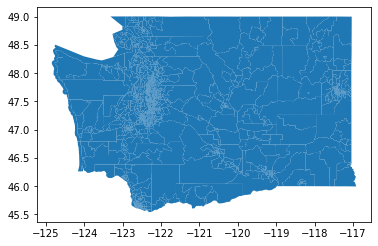

In [32]:
for_assign.reset_index(inplace=True,drop=True)
joined_demo_votes_gdf = pd.merge(for_assign,joined_demo_votes,on='TRACT',how='outer',indicator=True)
display(joined_demo_votes_gdf[joined_demo_votes_gdf['_merge']!='both'])
joined_demo_votes_col_order.append('geometry')
joined_demo_votes_gdf = joined_demo_votes_gdf[joined_demo_votes_col_order]
display(joined_demo_votes_gdf.head())
joined_demo_votes_gdf.plot()

In [33]:
joined_demo_votes_gdf.to_file('./wa_rpv_2020_tract.shp')

C:\Users\SpencerNelson\AppData\Local\Temp\ipykernel_11600\3794628197.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  joined_demo_votes_gdf.to_file('./wa_rpv_2020_tract.shp')
